# Training a Simple Memoized Agent With Simulation Cache
This notebook shows how to use the ```phyre``` API and simulation cache to train a simple memoized agent.

For introduction to the ```phyre``` API, see [PHYRE intro notebook](./01_phyre_intro.ipynb)

In the random agent example, we explored creating an agent that sampled actions at random from the action space of the tier. An alternate strategy is to have agents select or rank actions from a list of candidates. For this purpose, PHYRE provides a cache of the simulation results of 100k actions per task instance. The 100k actions in the cache are the same across all tasks. By only interacting with cached results of simulations, we can speed up the training process. This notebook shows how to build a simple memoized agent that selects actions based on the historical sucess rate of the action during training.

### Run this in colab
You can open and play with this notebook in colab. 
<a href="https://colab.research.google.com/github/facebookresearch/phyre/blob/master/examples/02_memoized_agent.ipynb" target="_parent">Open In Colab</a>

In [2]:
# Install phyre and auxiliary packages.
# !pip install phyre matplotlib tqdm ipywidgets

In [2]:
import functools
import multiprocessing
import random

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import phyre

In [3]:
tier = 'ball'
eval_setup = 'ball_cross_template'
fold_id = 0
random.seed(0)

# Part 1: The simulation cache
Let's explore how to use the simulation cache. To start, let's use the ball tier and evaluate our agent across templates.

We only use train and dev for building agents. In general test should be reserved for final evaluation of agents.

In [4]:
train, dev, test = phyre.get_fold(eval_setup, fold_id)
print(len(train), len(dev), len(test))

1600 400 500


Now let's load the cache. The cache contains 100k actions each simulated on each task in the ball tier.

In [5]:
cache = phyre.get_default_100k_cache(tier)

We can see which actions are cached by looking at the num-cached-actions X action-space ```action_array```. This array is built by `simulator.build_discrete_action_space` with a fixed seed=42.

In [6]:
print('cache.action_array() and shape:', cache.action_array.shape,
      cache.action_array)

cache.action_array() and shape: (100000, 3) [[0.5986585  0.15601864 0.15599452]
 [0.83244264 0.21233912 0.18182497]
 [0.1834045  0.30424225 0.52475643]
 ...
 [0.7356543  0.7556098  0.0149308 ]
 [0.8846895  0.6563959  0.8496121 ]
 [0.5163206  0.3238494  0.6627394 ]]


For each task, we can can get a corresponding 1D array of the status of each of the actions in ```action_array``` simulated on the task. The values -1, 0, and 1 corresponds to NOT_SOLVED, INVALID, and SOLVED statuses.

In [7]:
# task_id = random.choice(train)
task_id = random.choice(test)
print('Randomly selected task:', task_id)
statuses = cache.load_simulation_states(task_id)
print('Cached simulation status of actions on task', task_id, ':',
      statuses.shape, statuses)
print('Share of SOLVED statuses:', (statuses == phyre.SimulationStatus.SOLVED).mean())

Randomly selected task: 00019:439
Cached simulation status of actions on task 00019:439 : (100000,) [-1 -1 -1 ... -1 -1 -1]
Share of SOLVED statuses: 0.00053


Let's verify the status of a random action in the cache.

In [14]:
cached_status = phyre.simulation_cache.INVALID
while cached_status != 1:  # Let's make sure we chose a valid action.
    action_index = random.randint(0, len(cache))
    action = cache.action_array[action_index]
    # Get the status for this action from the cache.
    cached_status = statuses[action_index]

# Now let's create a simulator for this task to simulate the action.
simulator = phyre.initialize_simulator([task_id], tier)
simulation = simulator.simulate_action(0,
                                                     action,
                                                     need_images=True)

# Let's compare.
print('Cached status is:', cached_status)
print('Simulated status is:', simulation.status)
print('Simulator considers task solved?', simulation.status.is_solved())

Cached status is: 1
Simulated status is: SimulationStatus.NOT_SOLVED
Simulator considers task solved? False


Let's look at an image of the last state to visually verify if the task is solved.

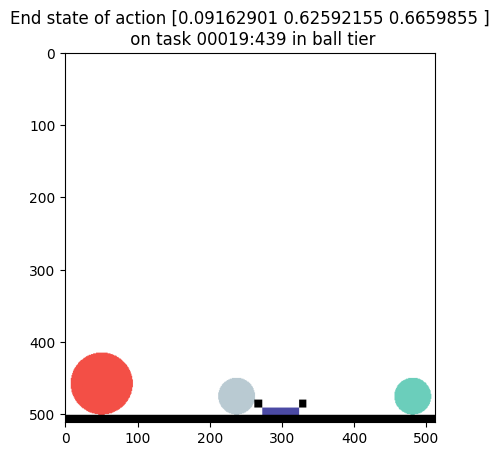

In [15]:
%matplotlib inline
img = phyre.vis.observations_to_float_rgb(simulation.images[-1])
plt.imshow(img)
plt.title(f'End state of action {action}\n on task {task_id} in {tier} tier')
plt.show()

Additionally, we can get cached results on a list of tasks. We can also limit the number of actions to the first N in the cache.

In [11]:
example_tasks = dev[:100]
cache_dict = cache.get_sample(example_tasks, 100)
print('The shape of actions in our small cache is',
      cache_dict['actions'].shape)

The shape of actions in our small cache is (100, 3)


In [12]:
print('The number and tasks in our small cache are',
      len(cache_dict['task_ids']), cache_dict['task_ids'])

The number and tasks in our small cache are 100 ('00000:000', '00000:001', '00000:002', '00000:003', '00000:004', '00000:005', '00000:006', '00000:007', '00000:008', '00000:009', '00000:010', '00000:011', '00000:012', '00000:013', '00000:014', '00000:015', '00000:016', '00000:017', '00000:018', '00000:019', '00000:020', '00000:021', '00000:022', '00000:023', '00000:024', '00000:025', '00000:026', '00000:027', '00000:028', '00000:029', '00000:030', '00000:031', '00000:032', '00000:033', '00000:034', '00000:035', '00000:036', '00000:037', '00000:038', '00000:039', '00000:040', '00000:041', '00000:042', '00000:043', '00000:044', '00000:045', '00000:046', '00000:047', '00000:048', '00000:049', '00000:050', '00000:051', '00000:052', '00000:053', '00000:054', '00000:055', '00000:056', '00000:057', '00000:058', '00000:059', '00000:060', '00000:061', '00000:062', '00000:063', '00000:064', '00000:065', '00000:066', '00000:067', '00000:068', '00000:069', '00000:070', '00000:071', '00000:072', '0

We also receive a status matrix simulation_statuses of size ```len(cache_dict['task_ids'])``` X ```len(cache_dict['actions'])``` where ```entry[i][j]``` is the status of simulating action ```cache_dict['actions'][j]``` on task id ```cache_dict['task_ids'][i]```

In [13]:
print('Simulation cache and shape', cache_dict['simulation_statuses'].shape,
      cache_dict['simulation_statuses'])

Simulation cache and shape (100, 100) [[-1 -1 -1 ... -1 -1 -1]
 [-1 -1  0 ... -1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1  0 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


We can visualize the status of the different actions on the tasks. In the visualization, each row corresponds to a specific task and each column to an action.

|Color|Simulation Status|
| :-------------: | :----------:|
|Purple|Not Solved|
|Yellow|Invalid Input|
|Green|Solved|

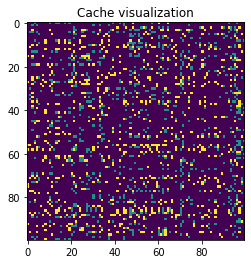

In [14]:
plt.imshow(cache_dict['simulation_statuses'], interpolation='nearest')
plt.title('Cache visualization')
plt.show()

# Part 2: Memoized Agent

We now build our agent. We will build a simple memoized agent. At training, the agent ranks actions based on the percentage of training tasks it solves. At test time, the agent uses the first ```max_attempts_per_task``` valid actions on each task in order of their rank.

As we are evaluating the performance across templates, the agent will have had no experience on any of the task templates in the test set, so the ranking of actions is the same accross templates.

In [15]:
def train_memo_agent(train_tasks, cache, max_actions_to_rank=None):
    cache_sample = cache.get_sample(train_tasks, max_actions_to_rank)
    sim_statuses = cache_sample['simulation_statuses']
    positive = (sim_statuses.astype('float32') > 0).sum(0)
    negative = (sim_statuses.astype('float32') < 0).sum(0)
    denominators = positive + negative + 1
    action_scores = positive / denominators
    # Return indices in order of the % tasks in the training set that the action solves.
    ordered_actions = action_scores.argsort()[::-1]
    return ordered_actions


def eval_memo_agent(eval_task_ids,
                    cache,
                    ordered_actions,
                    max_attempts_per_task,
                    n=1):
    # Evaluation of this agent is simple: record the status of the first max_attempts_per_task
    # valid actions on each task.
    evaluator = phyre.Evaluator(eval_task_ids)
    for task_index, task_id in tqdm.tqdm_notebook(
            enumerate(eval_task_ids),
            total=len(eval_task_ids),
            position=n,
            desc=f'Evaluate memo agent'):
        statuses = cache.load_simulation_states(task_id)
        for action_index in ordered_actions:
            status = phyre.SimulationStatus(statuses[action_index])
            evaluator.maybe_log_attempt(task_index, status)
            if evaluator.get_attempts_for_task(
                    task_index) >= max_attempts_per_task:
                break
    return evaluator

We can train and evaluate our agent, ranking all 100k actions.

In [16]:
ordered_actions = train_memo_agent(train, cache)
evaluator = eval_memo_agent(dev, cache, ordered_actions,
                            phyre.MAX_TEST_ATTEMPTS)

print('AUCESS after 100 attempts on dev set', evaluator.get_aucess())

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

AUCESS after 100 attempts on dev set 0.09299969491290087


We now explore the relationship between the number of actions that we rank and the performance of the agent.


In [17]:
memo_sizes = np.logspace(0, 5, 10).astype(int)


def worker(memo_size, train, dev, cache, max_attempts):
    index = 1 + np.where(memo_sizes == memo_size)[0][0]
    ordered_actions = train_memo_agent(train, cache, memo_size)
    evaluator = eval_memo_agent(dev, cache, ordered_actions, max_attempts,
                                index)
    return memo_size, evaluator.get_aucess()


# We use 10 threads to speed up the training process.
pool = multiprocessing.Pool(10)
partial_worker = functools.partial(
    worker,
    train=train,
    dev=dev,
    cache=cache,
    max_attempts=phyre.MAX_TEST_ATTEMPTS,
)
# NOTE: This can take ~ 2 minutes to run.
results = list(
    tqdm.tqdm_notebook(
        pool.imap(partial_worker, memo_sizes),
        total=len(memo_sizes),
        desc='Evaluate all memo sizes'))

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate all memo sizes:   0%|          | 0/10 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

/mnt/bn/yueyang/miniconda/envs/phyre/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate memo agent:   0%|          | 0/400 [00:00<?, ?it/s]

We graph the relationship between the number of ranked action, and AUCESS of the trained agent on the dev set.

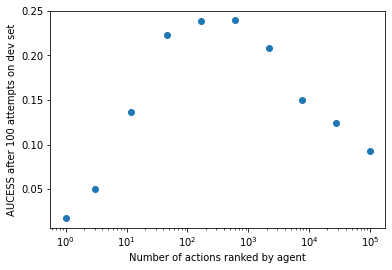

In [18]:
sizes, aucess = zip(*results)
plt.scatter(sizes, aucess)
plt.xscale('log')
plt.xlabel('Number of actions ranked by agent')
plt.ylabel('AUCESS after 100 attempts on dev set')
plt.show()

We note that the AUCESS plateaus, and eventually decrases after ranking a number of actions. This is due to a lack of diversity in the solutions required to solve some subsets of tasks. Some actions solve a large number of (easy) tasks, but the same subset of tasks. By ranking too many actions from the cache we risk having all the top performing actions (the 100 actions the memo agent chooses) all solve the same subset of tasks in the training set.